# Notebook for coverage plot optimization

- We want to generate coverage plots from Signac, but with our own style.

More specific goals are below:
- 1) Hack the basic coverage plot by accessing to the raw "fragments" file, generate coverage plot spanning certain region of the genome. (also with "group.by" parameters)
- 2) Use the Signac's default functions to create 

In [90]:
library(Seurat)
library(Signac)
library(patchwork)
library(ggplot2)


In [3]:
# import the Seurat object
TDR118 <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/TDR118_processed.rds")
TDR118

An object of class Seurat 
1055655 features across 13022 samples within 5 assays 
Active assay: ATAC (248320 features, 248320 variable features)
 4 other assays present: RNA, SCT, peaks_celltype, peaks_bulk
 8 dimensional reductions calculated: pca, umap, lsi, atac.umap, wnn.umap, umap.pca30, lsi.cellranger, atac.umap.cellranger

In [4]:
TDR118@assays$ATAC@fragments

[[1]]
A Fragment object for 13022 cells


In [9]:
# since we moved between servers, we need to update the filepath for the "Fragment" object within the Seurat object
# NOTE that we need to update it manually for every Signac object (ATAC object)
UpdatePath(TDR118@assays$ATAC@fragments[[1]], 
           "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz", 
           verbose = TRUE)

UpdatePath(TDR118@assays$peaks_celltype@fragments[[1]], 
           "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz", 
           verbose = TRUE)

UpdatePath(TDR118@assays$peaks_bulk@fragments[[1]], 
           "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz", 
           verbose = TRUE)

Computing hash



A Fragment object for 13022 cells

Computing hash



A Fragment object for 13022 cells

Computing hash



A Fragment object for 13022 cells

In [17]:
# updating the fragment filepath manually
TDR118@assays$ATAC@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"
TDR118@assays$peaks_celltype@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"
TDR118@assays$peaks_bulk@fragments[[1]]@path <- "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


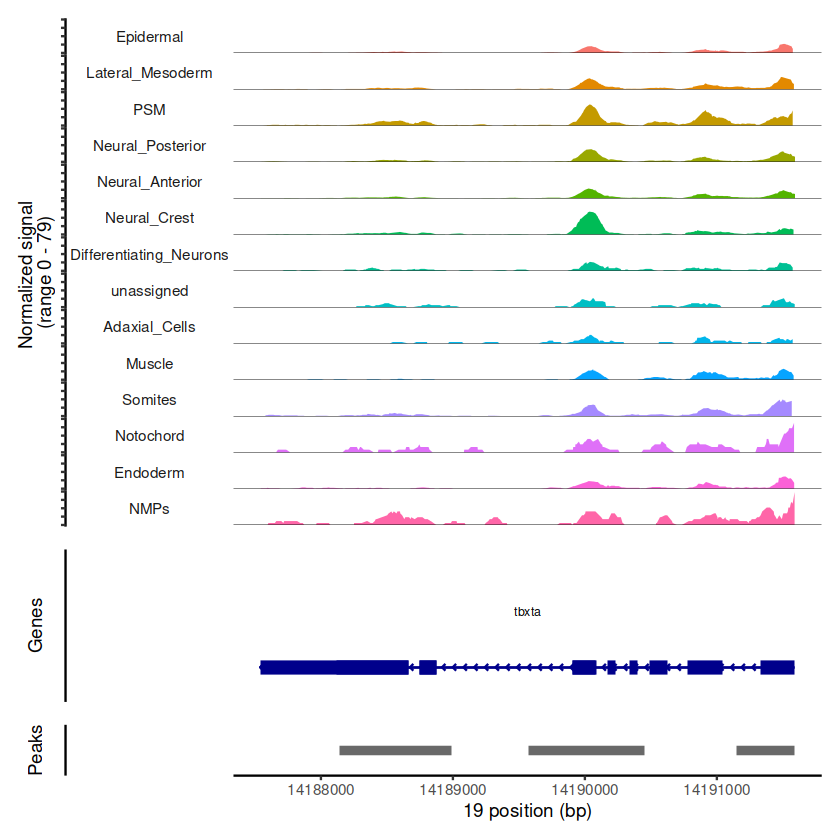

In [16]:
CoveragePlot(TDR118, region = "tbxta")

In [80]:
gene.coord <- LookupGeneCoords(object = TDR118, gene = "tbxta")
gene.coord

gene.coord.df <- as.data.frame(gene.coord)
gene.coord.df

GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]       19 14187540-14191592      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

seqnames,start,end,width,strand
<fct>,<int>,<int>,<int>,<fct>
19,14187540,14191592,4053,*


In [92]:
gene.coord <- LookupGeneCoords(object = TDR118, gene = "tbxta")
gene.coord

gene.coord.df <- as.data.frame(gene.coord)
gene.coord.df

chromosome <- gene.coord.df$seqnames
pos_start <- gene.coord.df$start
pos_end <-gene.coord.df$end

In [94]:
c(chromosome,"-",pos_start,"-",pos_end)

[1] "1"        "-"        "14187540" "-"        "14191592"

 Factor w/ 1 level "19": 1


Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


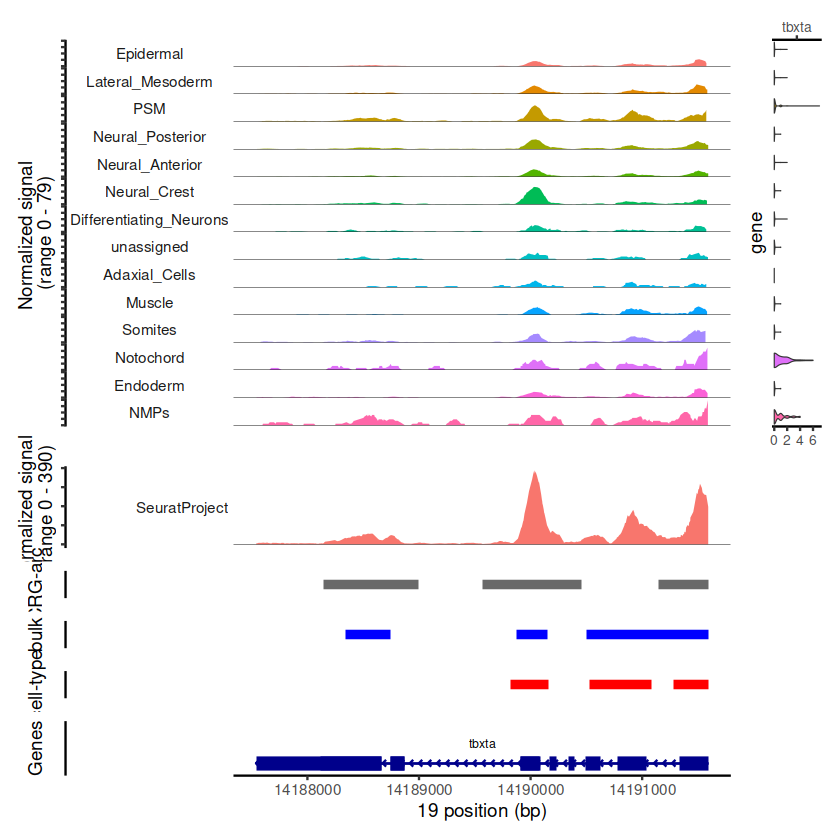

In [103]:
gene = "tbxta"

# Compare the called peaks using a Coverage Plot
Idents(TDR118) <- "orig.ident"

cov_plot_bulk <- CoveragePlot(
  object = TDR118,
  region = "tbxta",
  annotation=FALSE,
  peaks=FALSE
  #ranges = peaks,
  #ranges.title = "MACS2"
)

# we have to manually change the basic identity for Seurat
Idents(TDR118) <- "predicted.id"
cov_plot_celltype <- CoveragePlot(
    object = TDR118, 
    region = "tbxta",
    annotation = FALSE,
    peaks=FALSE
)

# gene annotation
gene_plot <- AnnotationPlot(
  object = TDR118,
  region = "19-14187540-14191592"
)
# gene_plot


# cellranger-arc peaks
peak_plot_CRG <- PeakPlot(
  object = TDR118,
  region = "19-14187540-14191592",
  peaks=TDR118@assays$ATAC@ranges
) + labs(y="CRG-arc")
# peak_plot

# MACS2-bulk peaks
peak_plot_bulk <- PeakPlot(
  object = TDR118,
  region = "19-14187540-14191592",
  peaks=TDR118@assays$peaks_bulk@ranges,
  color = "blue"
)+ labs(y="bulk")

# MACS2-cell-type-specific peaks
peak_plot_celltype <- PeakPlot(
  object = TDR118,
  region = "19-14187540-14191592",
  peaks=TDR118@assays$peaks_celltype@ranges,
  color = "red"
)+ labs(y="cell-type")

# expression of RNA
expr_plot <- ExpressionPlot(
  object = TDR118,
  features = "tbxta",
  assay = "RNA"
)

# Patchwork
# cov_plot/
# (cov_plot_celltype | expr_plot)/
# gene_plot/
# peak_plot_CRG/
# peak_plot_bulk/
# peak_plot_celltype

CombineTracks(
  plotlist = list(cov_plot_celltype, cov_plot_bulk, 
                  peak_plot_CRG, peak_plot_bulk, peak_plot_celltype, 
                  gene_plot),
  expression.plot = expr_plot,
  heights = c(10,3,1,1,1,2),
  widths = c(10, 1)
)

In [128]:
options(repr.plot.width = 8, repr.plot.height = 12, repr.plot.res = 300)

generate_coverage_plots <- function(object, gene, filepath){
    
      # Check if gene exists in GTF file
      if (!gene %in% object@assays$ATAC@annotation$gene_name) {
        cat("Gene", gene, "not found in GTF file. Skipping.\n")
        return(NULL)
      }
    
    # make sure that the major identity is "orig.ident" for bulk peak profile
    Idents(object) <- "orig.ident"
    # peak profile for the bulk counts
    cov_plot_bulk <- CoveragePlot(
      object = object,
      region = gene,
      annotation=FALSE,
      peaks=FALSE
      #ranges = peaks,
      #ranges.title = "MACS2"
    )

    # we have to manually change the basic identity for Seurat
    Idents(object) <- "predicted.id"
    
    # peak profile for the counts (cell-type, predicted.id)
    cov_plot_celltype <- CoveragePlot(
        object = object, 
        region = gene,
        annotation = FALSE,
        peaks=FALSE
    )
    
    # for gene/peak plots, we need to find the genomic locations as the old Signac doesn't take the gene name as an input argument.
    gene.coord <- LookupGeneCoords(object = object, gene = gene)
    gene.coord.df <- as.data.frame(gene.coord)
    
    # extract the chromosome number, start position and end position
    chromosome <- gene.coord.df$seqnames
    pos_start <- gene.coord.df$start
    pos_end <-gene.coord.df$end
    
    # compute the genomic region as "chromsome_number-start-end"
    genomic_region <- paste(chromosome, pos_start, pos_end, sep="-")
    
    # gene annotation
    gene_plot <- AnnotationPlot(
      object = object,
      region = genomic_region
    )
    # gene_plot


    # cellranger-arc peaks
    peak_plot_CRG <- PeakPlot(
      object = object,
      region = genomic_region,
      peaks=object@assays$ATAC@ranges
    ) + labs(y="CRG-arc")
    # peak_plot

    # MACS2-bulk peaks
    peak_plot_bulk <- PeakPlot(
      object = object,
      region = genomic_region,
      peaks=object@assays$peaks_bulk@ranges,
      color = "blue"
    )+ labs(y="bulk")

    # MACS2-cell-type-specific peaks
    peak_plot_celltype <- PeakPlot(
      object = object,
      region = genomic_region,
      peaks=object@assays$peaks_celltype@ranges,
      color = "red"
    )+ labs(y="cell-type")

    # expression of RNA
    expr_plot <- ExpressionPlot(
      object = object,
      features = gene,
      assay = "RNA"
    )

    plot<-CombineTracks(
      plotlist = list(cov_plot_celltype, cov_plot_bulk, 
                      peak_plot_CRG, peak_plot_bulk, peak_plot_celltype, 
                      gene_plot),
      expression.plot = expr_plot,
      heights = c(10,3,1,1,1,2),
      widths = c(10, 1)
    )
    
    options(repr.plot.width = 8, repr.plot.height = 12, repr.plot.res = 300)
#     ggsave(paste0(filepath, "coverage_plot_", gene, "_allpeaks.png"), plot=plot, width=8, height=12)
    return(plot)
    
}

# 

In [112]:
generate_coverage_plots(object = TDR118, gene = "tbxta", 
                        filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/coverage_plots_TDR118/")

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


In [118]:
list_genes <- list("lrrc17","comp","ripply1","rx1","vsx2","tbx16","myf5",
                   "hes6","crestin","ednrab","dlx2a","cldni","cfl1l",
                   "fezf1","sox1b","foxg1a","olig3","hoxd4a","rxrga",
                   "gata5","myh7","tnnt2a",'pkd1b',"scg3","etv5a","pitx3",
                   "elavl3","stmn1b","sncb","myog","myl1","jam2a",
                   "prrx1","nid1b","cpox","gata1a","hbbe1","unc45b","ttn1",
                   "apobec2a","foxi3b","atp1b1b","fli1b","kdrl","anxa4",
                   "cldnc","cldn15a","tbx3b","loxl5b","emilin3a","sema3aa","irx7","vegfaa",
                   "ppl","krt17","icn2","osr1","hand2","shha","shhb","foxa2",
                   "cebpa","spi1b","myb","ctslb","surf4l","sec61a1l","mcf2lb",
                   "bricd5","etnk1","chd17","acy3")
list_genes

[[1]]
[1] "lrrc17"

[[2]]
[1] "comp"

[[3]]
[1] "ripply1"

[[4]]
[1] "rx1"

[[5]]
[1] "vsx2"

[[6]]
[1] "tbx16"

[[7]]
[1] "myf5"

[[8]]
[1] "hes6"

[[9]]
[1] "crestin"

[[10]]
[1] "ednrab"

[[11]]
[1] "dlx2a"

[[12]]
[1] "cldni"

[[13]]
[1] "cfl1l"

[[14]]
[1] "fezf1"

[[15]]
[1] "sox1b"

[[16]]
[1] "foxg1a"

[[17]]
[1] "olig3"

[[18]]
[1] "hoxd4a"

[[19]]
[1] "rxrga"

[[20]]
[1] "gata5"

[[21]]
[1] "myh7"

[[22]]
[1] "tnnt2a"

[[23]]
[1] "pkd1b"

[[24]]
[1] "scg3"

[[25]]
[1] "etv5a"

[[26]]
[1] "pitx3"

[[27]]
[1] "elavl3"

[[28]]
[1] "stmn1b"

[[29]]
[1] "sncb"

[[30]]
[1] "myog"

[[31]]
[1] "myl1"

[[32]]
[1] "jam2a"

[[33]]
[1] "prrx1"

[[34]]
[1] "nid1b"

[[35]]
[1] "cpox"

[[36]]
[1] "gata1a"

[[37]]
[1] "hbbe1"

[[38]]
[1] "unc45b"

[[39]]
[1] "ttn1"

[[40]]
[1] "apobec2a"

[[41]]
[1] "foxi3b"

[[42]]
[1] "atp1b1b"

[[43]]
[1] "fli1b"

[[44]]
[1] "kdrl"

[[45]]
[1] "anxa4"

[[46]]
[1] "cldnc"

[[47]]
[1] "cldn15a"

[[48]]
[1] "tbx3b"

[[49]]
[1] "loxl5b"

[[50]]
[1] "emilin3a"

[[51]]
[1] "sema3aa"

[[52]]
[1] "irx7"

[[53]]
[1] "vegfaa"

[[54]]
[1] "ppl"

[[55]]
[1] "krt17"

[[56]]
[1] "icn2"

[[57]]
[1] "osr1"

[[58]]
[1] "hand2"

[[59]]
[1] "shha"

[[60]]
[1] "shhb"

[[61]]
[1] "foxa2"

[[62]]
[1] "cebpa"

[[63]]
[1] "spi1b"

[[64]]
[1] "myb"

[[65]]
[1] "ctslb"

[[66]]
[1] "surf4l"

[[67]]
[1] "sec61a1l"

[[68]]
[1] "mcf2lb"

[[69]]
[1] "bricd5"

[[70]]
[1] "etnk1"

[[71]]
[1] "chd17"

[[72]]
[1] "acy3"

In [117]:
list_genes <- unique(list_genes)
list_genes

[[1]]
[1] "lrrc17"

[[2]]
[1] "comp"

[[3]]
[1] "ripply1"

[[4]]
[1] "rx1"

[[5]]
[1] "vsx2"

[[6]]
[1] "tbx16"

[[7]]
[1] "myf5"

[[8]]
[1] "hes6"

[[9]]
[1] "crestin"

[[10]]
[1] "ednrab"

[[11]]
[1] "dlx2a"

[[12]]
[1] "cldni"

[[13]]
[1] "cfl1l"

[[14]]
[1] "fezf1"

[[15]]
[1] "sox1b"

[[16]]
[1] "foxg1a"

[[17]]
[1] "olig3"

[[18]]
[1] "hoxd4a"

[[19]]
[1] "rxrga"

[[20]]
[1] "gata5"

[[21]]
[1] "myh7"

[[22]]
[1] "tnnt2a"

[[23]]
[1] "pkd1b"

[[24]]
[1] "scg3"

[[25]]
[1] "etv5a"

[[26]]
[1] "pitx3"

[[27]]
[1] "elavl3"

[[28]]
[1] "stmn1b"

[[29]]
[1] "sncb"

[[30]]
[1] "myog"

[[31]]
[1] "myl1"

[[32]]
[1] "jam2a"

[[33]]
[1] "prrx1"

[[34]]
[1] "nid1b"

[[35]]
[1] "cpox"

[[36]]
[1] "gata1a"

[[37]]
[1] "hbbe1"

[[38]]
[1] "unc45b"

[[39]]
[1] "ttn1"

[[40]]
[1] "apobec2a"

[[41]]
[1] "foxi3b"

[[42]]
[1] "atp1b1b"

[[43]]
[1] "fli1b"

[[44]]
[1] "kdrl"

[[45]]
[1] "anxa4"

[[46]]
[1] "cldnc"

[[47]]
[1] "cldn15a"

[[48]]
[1] "tbx3b"

[[49]]
[1] "loxl5b"

[[50]]
[1] "emilin3a"

[[51]]
[1] "sema3aa"

[[52]]
[1] "irx7"

[[53]]
[1] "vegfaa"

[[54]]
[1] "ppl"

[[55]]
[1] "krt17"

[[56]]
[1] "icn2"

[[57]]
[1] "osr1"

[[58]]
[1] "hand2"

[[59]]
[1] "shha"

[[60]]
[1] "shhb"

[[61]]
[1] "foxa2"

[[62]]
[1] "cebpa"

[[63]]
[1] "spi1b"

[[64]]
[1] "myb"

[[65]]
[1] "ctslb"

[[66]]
[1] "surf4l"

[[67]]
[1] "sec61a1l"

[[68]]
[1] "mcf2lb"

[[69]]
[1] "bricd5"

[[70]]
[1] "etnk1"

[[71]]
[1] "chd17"

[[72]]
[1] "acy3"

In [ ]:
# # Create a list to store the plot objects
# plot_list <- list()

# # Loop over 20 genes
# for (gene in list_genes) {
#   # Generate the coverage plot for the gene
#   plot <- generate_coverage_plots(TDR118, gene)
  
#   # Add the plot object to the list
#   plot_list[[gene]] <- plot
# }

# Create a PDF file
pdf("coverage_plots_15somite_marker_genes.pdf")

# Loop over the plot list and save each plot to a separate page in the PDF
for (gene in list_genes) {
  plot <- plot_list[[gene]]
  print(plot)
}

# Close the PDF file
dev.off()

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 23 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows contai

NULL


Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


NULL


Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


NULL


Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows contain

Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


$lrrc17


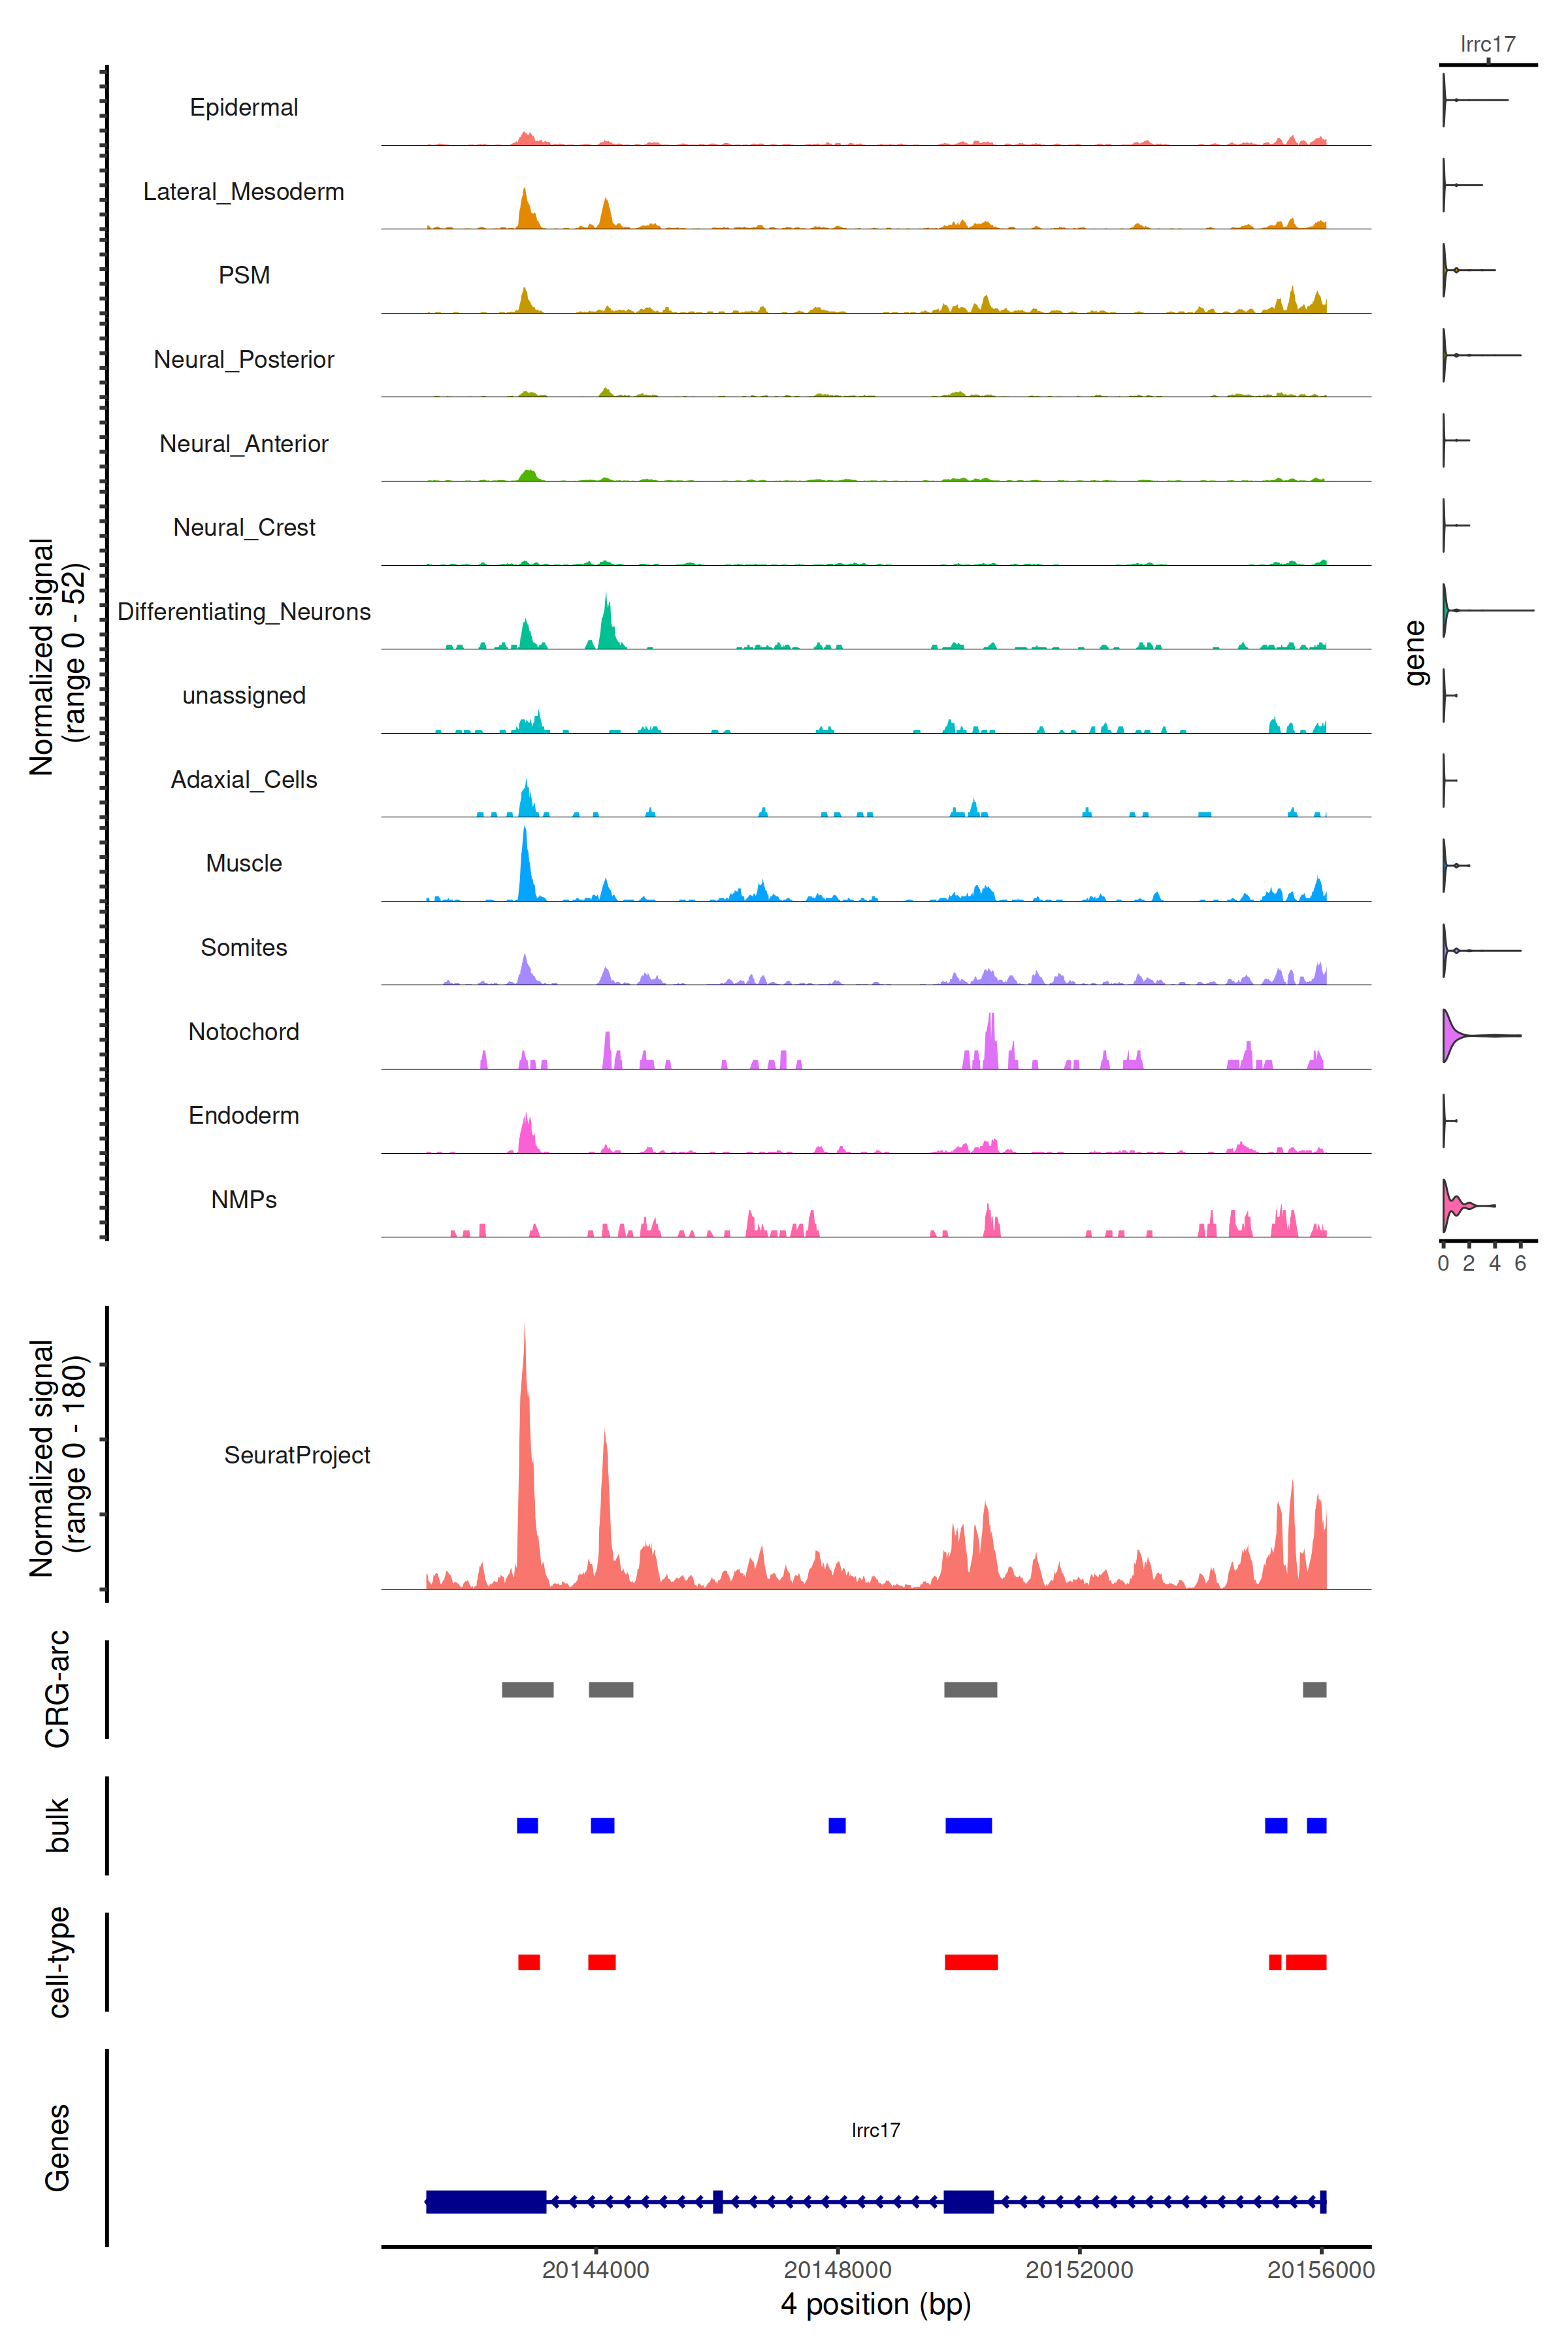

In [134]:
plot_list[1]

## Hacking the Coverage Plot function

In [28]:
as.data.frame(TDR118@assays$ATAC@fragments[[1]])

ERROR: Error in as.data.frame.default(TDR118@assays$ATAC@fragments[[1]]): cannot coerce class ‘structure("Fragment", package = "Signac")’ to a data.frame


In [48]:
fragments <- TDR118@assays$ATAC@fragments[[1]]
fragments

A Fragment object for 13022 cells

In [36]:
GetFragmentData(fragments, slot="path")

[1] "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"

In [42]:
head(TDR118@assays$ATAC@fragments[[1]])

chrom,start,end,barcode,readCount
<int>,<int>,<int>,<chr>,<int>
1,7,134,TACGGTTAGGACAACA-1,2
1,15,611,TCGGTTCTCTTTGAGA-1,3
1,17,47,CCCTCACCAAGGGTTG-1,3
1,19,198,ACTAAAGCAGGCTTCG-1,3
1,41,121,GTAGCGCTCTAAGGAG-1,5
1,50,91,TCCTGTTCAGGCTTGT-1,8


In [50]:
head(fragments)

chrom,start,end,barcode,readCount
<int>,<int>,<int>,<chr>,<int>
1,7,134,TACGGTTAGGACAACA-1,2
1,15,611,TCGGTTCTCTTTGAGA-1,3
1,17,47,CCCTCACCAAGGGTTG-1,3
1,19,198,ACTAAAGCAGGCTTCG-1,3
1,41,121,GTAGCGCTCTAAGGAG-1,5
1,50,91,TCCTGTTCAGGCTTGT-1,8


In [53]:
class(fragments)
str(fragments)

[1] "Fragment"
attr(,"package")
[1] "Signac"

Formal class 'Fragment' [package "Signac"] with 3 slots
  ..@ path : chr "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118/outs/atac_fragments.tsv.gz"
  ..@ hash : chr [1:2] "8ae7d119ba482dd95730ba9e6179f788" "4c53b0fe50688a66a619ee77d057ce02"
  ..@ cells: Named chr [1:13022] "AAACAGCCACCTAAGC-1" "AAACAGCCAGGGAGGA-1" "AAACAGCCATAGACCC-1" "AAACATGCAAACTCAT-1" ...
  .. ..- attr(*, "names")= chr [1:13022] "AAACAGCCACCTAAGC-1" "AAACAGCCAGGGAGGA-1" "AAACAGCCATAGACCC-1" "AAACATGCAAACTCAT-1" ...
  .. ..- attr(*, ".match.hash")=Class 'match.hash' <externalptr> 


In [55]:
frag_df <- data.frame(
  chrom = fragments@chrom,
  start = fragments@start,
  end = fragments@end,
  barcode = fragments@cells,
  readCount = fragments@readCount
)

head(frag_df)

ERROR: Error in data.frame(chrom = fragments@chrom, start = fragments@start, : no slot of name "chrom" for this object of class "Fragment"


In [56]:
frag_df <- as.data.frame(fragments)

head(frag_df[, c("chrom", "start", "end", "barcode", "readCount")])

ERROR: Error in as.data.frame.default(fragments): cannot coerce class ‘structure("Fragment", package = "Signac")’ to a data.frame


In [58]:
frag_df <- data.frame(
  chrom = fragments@ranges@seqnames,
  start = start(fragments@ranges),
  end = end(fragments@ranges),
  barcode = fragments@cells,
  readCount = fragments@readCount
)

head(frag_df)

ERROR: Error in data.frame(chrom = fragments@ranges@seqnames, start = start(fragments@ranges), : no slot of name "ranges" for this object of class "Fragment"


In [60]:
frag_df <- data.frame(
  chrom = fragments@regions@seqnames,
  start = start(fragments@regions),
  end = end(fragments@regions),
  barcode = fragments@cells,
  readCount = fragments@readCount
)

head(frag_df)

ERROR: Error in data.frame(chrom = fragments@regions@seqnames, start = start(fragments@regions), : no slot of name "regions" for this object of class "Fragment"
